# MUVA 2022/23 - Imagen Médica
## Práctica 2: Registro de Imágenes Médicas
### Grupo 4: Pablo Ríos y Celia García

# 2. Implementación de un algoritmo de registro

El objetivo de este apartado es implementar en Python un algoritmo de registro
rígido.

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib

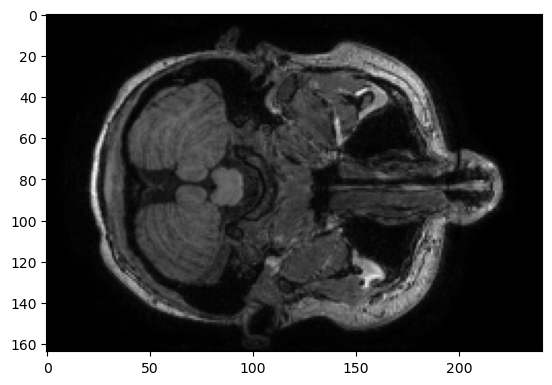

In [44]:
# Cargamos una imagen del apartado anterior
img = nib.load('material/mr1.nii').get_fdata()[:, :, 100]

plt.imshow(img, cmap='gray')

Rotación de la imagen

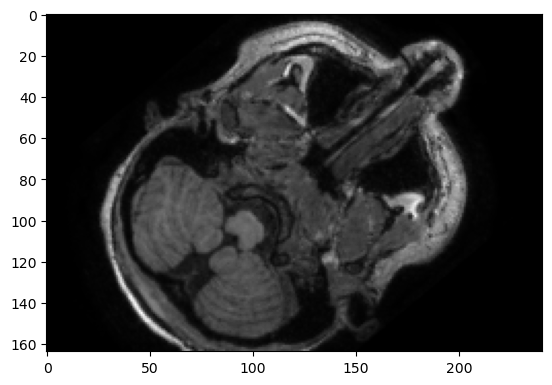

In [185]:
rotation_angle = 40
M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotation_angle, 1)
rotated_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

plt.imshow(rotated_img, cmap='gray')

### 2.1 Transformación: Crear una función que aplique una transformación rígida a una imagen con los parámetros que se le pasan como entrada.

In [186]:
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    """
    Rotates an image (angle in degrees).
    :param image: np.ndarray Image to be rotated
    :param angle: float Angle of rotation in degrees
    :return: np.ndarray Rotated image
    """

    theta = np.deg2rad(angle)
    h, w = image.shape[:2]

    T = np.array([[1, 0, -w/2],
                  [0, 1, -h/2],
                  [0, 0, 1]])

    M = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])

    R = np.linalg.inv(T) @ M @ T

    rotated = np.zeros_like(image)
    for y in range(h):
        for x in range(w):
            # Calculate the position
            pos = R @ np.array([x, y, 1])
            pos = pos / pos[2]
            pos = np.round(pos[:2]).astype(np.int32)

            # Check if position with the size of the image
            if 0 <= pos[1] < h and 0 <= pos[0] < w:
                rotated[y, x] = image[pos[1], pos[0]]

    return rotated


Conociendo el ángulo de giro de la imagen original, se comprueba que la función funciona correctamente.

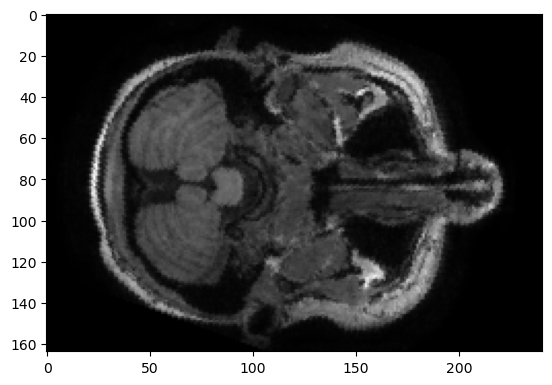

In [45]:
correct_img = rotate_image(rotated_img, -rotation_angle)
plt.imshow(correct_img, cmap='gray');

### 2.2 Interpolación: Crear una función que interpole la imagen transformada, usando interpolación trilineal.

In [49]:
from scipy.interpolate import griddata

def lineal_interpolation(image: np.ndarray) -> np.ndarray:

    h, w = image.shape[:2]

    # Creamos una matriz que representa las coordenadas de los píxeles
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Convertimos las matrices x e y en vectores
    x, y = x.flatten(),  y.flatten()

    # Convertimos la matriz de imagen en un vector
    z = image.flatten()

    # Creamos una función de interpolación lineal a partir de la imagen
    interpolation_function = griddata((x, y), z, (x, y), method='linear')

    # Convertimos el resultado en una matriz
    interpolated_image = interpolation_function.reshape((h, w))

    return interpolated_image

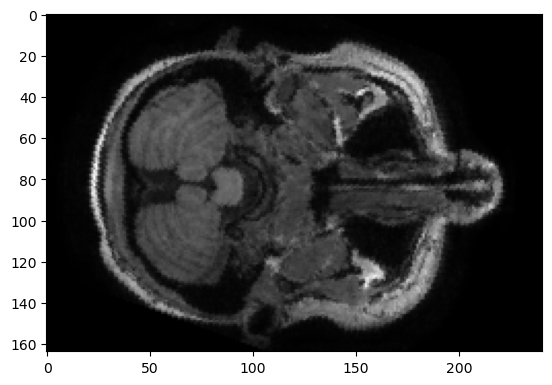

In [51]:
inter_img = lineal_interpolation(correct_img)
plt.imshow(inter_img, cmap='gray');

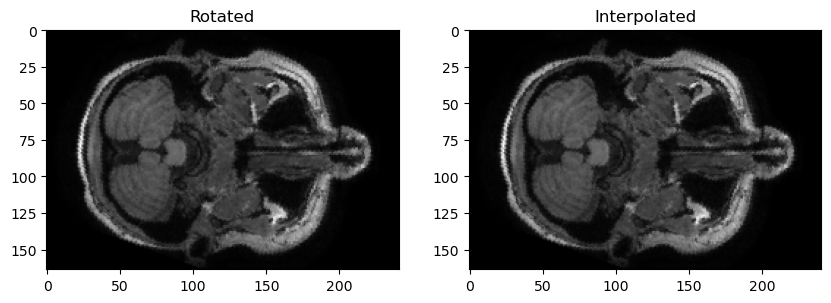

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Plot the first image on the left axis
axes[0].imshow(correct_img, cmap='gray')
axes[0].set_title('Rotated')

# Plot the second image on the right axis
axes[1].imshow(inter_img, cmap='gray')
axes[1].set_title('Interpolated')

# Show the plot
plt.show()

### 2.3 Métrica: Crear una función que calcule la métrica de información mutua a partir de dos imágenes.

In [126]:
def mutual_information(image1: np.ndarray, image2: np.ndarray) -> float:
    """
    Calculates the mutual information between two images.
    :param image1: np.ndarray First image
    :param image2: np.ndarray Second image
    :return: float Mutual information
    """
    image_f1 = image1 / 255.
    image_f2 = image2 / 255.

    # Entropy of images
    hist1, _ = np.histogram(image_f1, bins=256)
    hist2, _ = np.histogram(image_f2, bins=256)
    prob1, prob2 = hist1/np.sum(hist1), hist2/np.sum(hist2)

    entropy1, entropy2 = -np.sum(prob1 * np.log2(prob1 + 1e-10)), -np.sum(prob2 * np.log2(prob2 + 1e-10))

    # Joint entropy
    joint_hist, _, _ = np.histogram2d(image_f1.flatten(), image_f2.flatten(), bins=256)
    joint_entropy = -np.sum(joint_hist/np.sum(joint_hist) * np.log2(joint_hist/np.sum(joint_hist) + 1e-10))

    # Mutual information
    mutual_info = entropy1 + entropy2 - joint_entropy
    return mutual_info

In [132]:
mutual_information(img, correct_img)

2.9423941801853353

### 2.4 Optimización: Seleccionar una función de optimización que emplearemos para optimizar los parámetros de la transformación en cada iteración.

In [187]:
from scipy.optimize import minimize
from scipy.ndimage import rotate

In [207]:
angle_rotation = 20

img = nib.load('material/mr1.nii').get_fdata()[:, :, 100]
rotated_img = rotate(img, angle_rotation, order=3, reshape=False)

In [208]:
def f(params, img_fixed, img_moving):
    angle = params[0]
    rotated_img = rotate(img_moving, angle, order=3, reshape=False)
    diff = np.abs(img_fixed - rotated_img)
    return np.sum(diff)

def fit(params, img_fixed, img_moving):
    return minimize(fun=f, x0=params, args=(img_fixed, img_moving), method='Powell')

params = np.array([[0.0]])

ddre = fit(params, img, rotated_img)

print(f"El angulo de rotación es: {ddre.x[0]}" )

El angulo de rotación es: -19.99972731874777
